<a href="https://colab.research.google.com/github/tabaraei/aspect-based-sentiment-analysis/blob/main/ABSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Born and explanations provided to understand why the opinion is positive or negative, and at the end compare it with pre-trained model.

[Born Classifier](https://bornrule.eguidotti.com) is a text classification algorithm inspired by the notion of superposition of states in quantum
physics. Born provides good classification performance, explainability, and computational efficiency. In this
project, the goal is to exploit the Born explanation in order to use it for Aspect Based Sentiment Analysis. In
particular, the main idea to to proceed as follows:
1. Perform a sentiment analysis classification of documents using Born ✅
2. Extract the explanation features for each pair of documents and predicted labels ✅
3. Analyze the explanatory features in order to group them in candidate aspects ✅
4. Associate each aspect to a specific sentence or portion of the text ✅
5. Predict the sentiment for the sentence or text portion using the trained Born classifier ✅
6. Associate then a (potentially different) sentiment to each sentence or text portion according to the aspect
7. Finally, evaluate the quality of the results for each aspect. ✅

## Libraries and Modules

In [1]:
%%capture
!python -m spacy download en_core_web_lg

from google.colab import drive
import kagglehub
import os
import joblib
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import spacy
from IPython.display import display


nlp = spacy.load('en_core_web_sm')
drive.mount('/content/drive')
SAVE_DRIVE_PATH = '/content/drive/MyDrive/Data/ABSA'

In [2]:
%%capture
!pip install datasets
!pip install bornrule

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from bornrule import BornClassifier

warnings.filterwarnings('ignore')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

## Datasets

### Amazon Reviews Dataset (Sentiment Analysis)

In [3]:
class AmazonReviewsDataset:
    def __init__(self):
        self.KAGGLE_DATASET_PATH = 'snap/amazon-fine-food-reviews'
        self.create_dataset()
        self.class_labels = sorted(self.dataset['Sentiment'].unique())

    def map_score_to_sentiment(self, score):
        if score < 3: return 'negative'
        elif score == 3: return 'neutral'
        elif score > 3: return 'positive'

    def create_dataset(self):
        # Define the dataset path in Kaggle and current directory
        kaggle_path = kagglehub.dataset_download(self.KAGGLE_DATASET_PATH)
        path = os.path.join(kaggle_path, 'Reviews.csv')

        # Load and transform the dataset
        self.dataset = pd.read_csv(path, nrows=50)
        self.dataset['Sentiment'] = self.dataset['Score'].apply(self.map_score_to_sentiment)
        self.dataset = self.dataset.rename(columns={'Text': 'Document'})[['Document', 'Sentiment']]

        # Prepare the train/test splits
        self.train_df, self.test_df = \
            train_test_split(self.dataset, test_size=0.2, random_state=42, stratify=self.dataset['Sentiment'])
        self.train_df = self.train_df.reset_index(drop=True)
        self.test_df = self.test_df.reset_index(drop=True)

In [4]:
amazon = AmazonReviewsDataset()
amazon.dataset.head()

100%|██████████| 242M/242M [00:03<00:00, 80.1MB/s]


,Document,Sentiment
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive


### SemEval2014 Dataset (Aspect-based Sentiment Analysis)

Any dataset supporting ABSA. See for example [here](https://paperswithcode.com/datasets?task=aspect-based-sentiment-analysis&page=1).

In [5]:
class SemEval2014Dataset:
    def __init__(self, task='restaurants'):
        # Load the "restaurants" or "laptops" datasets from SemEval2014 in HuggingFace
        self.HUGGING_FACE_DATASET_PATH = 'alexcadillon/SemEval2014Task4'
        self.task = task
        self.create_dataset()
        self.class_labels = sorted(self.dataset['Sentiment'].unique())

    def compute_overall_sentiment(self, aspect_sentiments):
        pos_count = aspect_sentiments.count('positive')
        neg_count = aspect_sentiments.count('negative')

        if pos_count > neg_count:
            return 'positive'
        elif neg_count > pos_count:
            return 'negative'
        else:
            return 'neutral'

    def transform_dataset(self, df):
        data = []
        for entry in df:
            document = entry['text']
            aspects = [aspect['term'] for aspect in entry['aspectTerms']]
            aspect_sentiments = [aspect['polarity'] for aspect in entry['aspectTerms']]
            overall_sentiment = self.compute_overall_sentiment(aspect_sentiments)
            data.append({
                'Document': document,
                'Aspects': aspects,
                'Aspect_Sentiments': aspect_sentiments,
                'Sentiment': overall_sentiment
            })
        return pd.DataFrame(data)

    def create_dataset(self):
        dataset = load_dataset(self.HUGGING_FACE_DATASET_PATH, self.task)
        self.train_df = self.transform_dataset(dataset['train'])
        self.test_df = self.transform_dataset(dataset['test'])
        self.dataset = pd.concat([self.train_df, self.test_df], ignore_index=True)

In [6]:
semeval = SemEval2014Dataset(task='restaurants')
semeval.dataset.head()

SemEval2014Task4.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Generating trial split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/3041 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/800 [00:00<?, ? examples/s]

,Document,Aspects,Aspect_Sentiments,Sentiment
0,But the staff was so horrible to us.,[staff],[negative],negative
1,"To be completely fair, the only redeeming fact...",[food],[positive],positive
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]",positive
3,Where Gabriela personaly greets you and recomm...,[],[],neutral
4,"For those that go once and don't enjoy it, all...",[],[],neutral


## Sentiment Analysis using Born

In [37]:
class Visualization:
    def confusion_matrix(self, cm, pred_labels, true_labels):
        plt.figure(figsize=(8, 4))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=pred_labels, yticklabels=true_labels)
        ax.set(xlabel='Predicted Labels', ylabel='True Labels', title='Confusion Matrix')

    def visualize_aspect_detection_evaluation(metrics_df):
        plt.figure(figsize=(10, 6))
        ax = sns.lineplot(data=metrics_df, x='Threshold', y='Value', hue='Metric', marker='o', palette='Set2')
        ax.set_ylim(0, 1)
        ax.set(xlabel='Threshold', ylabel='Metric Value', title='Evaluation Metrics vs Thresholds')

visualize = Visualization()

In [38]:
class SentimentAnalysis:
    def __init__(self, train_df, test_df, class_labels):
        self.train_df = train_df
        self.test_df = test_df
        self.class_labels = class_labels
        self.vectorize_documents()

    def vectorize_documents(self):
        self.vec = CountVectorizer(tokenizer=word_tokenize, lowercase=True, token_pattern=None)
        self.X_train = self.vec.fit_transform(self.train_df['Document'])
        self.X_test = self.vec.transform(self.test_df['Document'])
        self.y_train = self.train_df['Sentiment']
        self.y_test = self.test_df['Sentiment']
        self.features = self.vec.get_feature_names_out()
        print(f'Number of features: {len(self.features)}\n')

    def train_and_test(self):
        self.clf = BornClassifier()
        self.clf.fit(self.X_train, self.y_train)
        self.global_explain = pd.DataFrame(self.clf.explain().toarray(), index=self.features, columns=self.class_labels)

        self.y_pred = self.clf.predict(self.X_test)
        print(classification_report(self.y_test, self.y_pred))

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred, labels=self.class_labels)
        visualize.confusion_matrix(cm, pred_labels=self.class_labels, true_labels=self.class_labels)

    def analyze_prediction_for_document(self, document_id, train_or_test='test'):
        if train_or_test == 'train':
            df = self.train_df
            X = self.X_train
        elif train_or_test == 'test':
            df = self.test_df
            X = self.X_test

        document = df.loc[document_id, 'Document']
        sentiment = df.loc[document_id, 'Sentiment']
        vectorized_doc = X[document_id]
        prediction = self.clf.predict(vectorized_doc)[0]
        print(f'Document: {document}\nTrue Sentiment: {sentiment}\nPrediction: {prediction}\n')
        return pd.DataFrame(self.clf.predict_proba(vectorized_doc), columns=self.class_labels, index=['probability'])

    # def initialize_explain(self, train_or_test='test'):
    #     if train_or_test == 'train':
    #         self.explain_local = pd.DataFrame(
    #             self.clf.explain(self.X_train).toarray(),
    #             index=self.features,
    #             columns=self.class_labels
    #         )
    #     else:
    #         self.explain_local = pd.DataFrame(
    #             self.clf.explain(self.X_test).toarray(),
    #             index=self.features,
    #             columns=self.class_labels
    #         )

    def get_global_explain(self):
        positive = self.global_explain['positive'].sort_values(ascending=False)
        neutral = self.global_explain['neutral'].sort_values(ascending=False)
        negative = self.global_explain['negative'].sort_values(ascending=False)
        return negative, neutral, positive

### Train and Test on `AmazonReviewsDataset`



Number of features: 755

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    positive       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.27      0.33      0.30        10
weighted avg       0.64      0.80      0.71        10



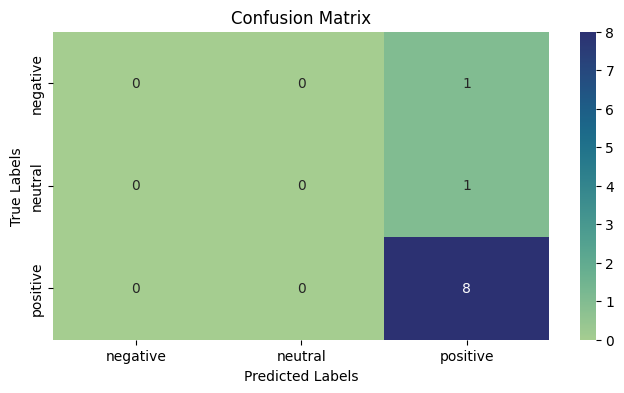

In [39]:
load_dataset = False

if load_dataset:
    amazon_sentiment_analysis = joblib.load(f'{SAVE_DRIVE_PATH}/amazon_sentiment_analysis.pkl')
else:
    amazon_sentiment_analysis = SentimentAnalysis(
        train_df=amazon.train_df,
        test_df=amazon.test_df,
        class_labels=amazon.class_labels
    )
    joblib.dump(amazon_sentiment_analysis, f'{SAVE_DRIVE_PATH}/amazon_sentiment_analysis.pkl')

amazon_sentiment_analysis.train_and_test()
amazon_sentiment_analysis.visualize_confusion_matrix()

In [40]:
amazon_sentiment_analysis.analyze_prediction_for_document(document_id=0, train_or_test='test')

Document: This seems a little more wholesome than some of the supermarket brands, but it is somewhat mushy and doesn't have quite as much flavor either.  It didn't pass muster with my kids, so I probably won't buy it again.
True Sentiment: neutral
Prediction: positive



,negative,neutral,positive
probability,0.282283,0.061045,0.656672


In [41]:
negative, neutral, positive = amazon_sentiment_analysis.get_global_explain()
display(positive.head()), display(neutral.head()), display(negative.head())

,positive
>,0.124785
<,0.124785
/,0.111030
br,0.111030
a,0.100380


,neutral
mushy,0.141421
oaker,0.141421
differce,0.141421
see,0.141421
any,0.131003


,negative
flavor,0.125153
jumbo,0.116248
peanuts,0.116248
red,0.111803
again,0.111803


(None, None, None)

### Train and Test on `SemEval2014Dataset`

Number of features: 4592

              precision    recall  f1-score   support

    negative       0.51      0.58      0.55       125
     neutral       0.72      0.57      0.63       279
    positive       0.74      0.82      0.78       396

    accuracy                           0.70       800
   macro avg       0.66      0.66      0.65       800
weighted avg       0.70      0.70      0.69       800



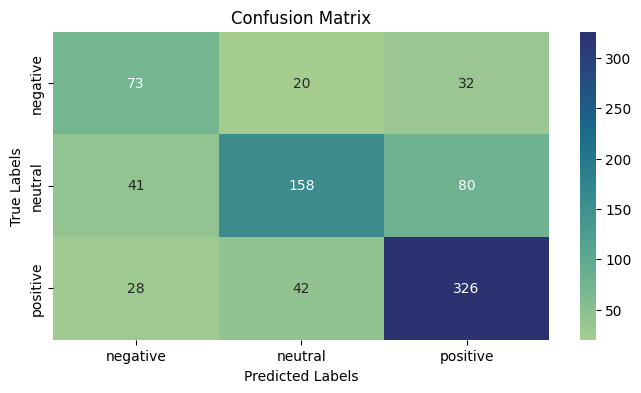

In [42]:
load_dataset = False

if load_dataset:
    semeval_sentiment_analysis = joblib.load(f'{SAVE_DRIVE_PATH}/semeval_sentiment_analysis.pkl')
else:
    semeval_sentiment_analysis = SentimentAnalysis(
        train_df=semeval.train_df,
        test_df=semeval.test_df,
        class_labels=semeval.class_labels
    )
    joblib.dump(semeval_sentiment_analysis, f'{SAVE_DRIVE_PATH}/semeval_sentiment_analysis.pkl')

semeval_sentiment_analysis.train_and_test()
semeval_sentiment_analysis.visualize_confusion_matrix()

In [43]:
semeval_sentiment_analysis.analyze_prediction_for_document(document_id=0, train_or_test='test')

Document: The bread is top notch as well.
True Sentiment: positive
Prediction: positive



,negative,neutral,positive
probability,0.146435,0.174319,0.679246


In [44]:
negative, neutral, positive = semeval_sentiment_analysis.get_global_explain()
display(negative.head()), display(neutral.head()), display(positive.head())

,negative
awful,0.034837
bland,0.029271
waiting,0.028652
lousy,0.026456
worst,0.026351


,neutral
pleasantly,0.027895
unbelievable,0.026978
kudos,0.023363
recommended,0.023135
highly,0.022633


,positive
friendly,0.034340
attentive,0.033205
reasonable,0.032684
great,0.030946
yummy,0.028073


(None, None, None)

### Train on `AmazonReviewsDataset`, Test on `SemEval2014Dataset`

Number of features: 890

              precision    recall  f1-score   support

    negative       0.16      0.11      0.13       575
     neutral       0.54      0.09      0.16      1653
    positive       0.43      0.85      0.57      1613

    accuracy                           0.41      3841
   macro avg       0.38      0.35      0.29      3841
weighted avg       0.44      0.41      0.33      3841



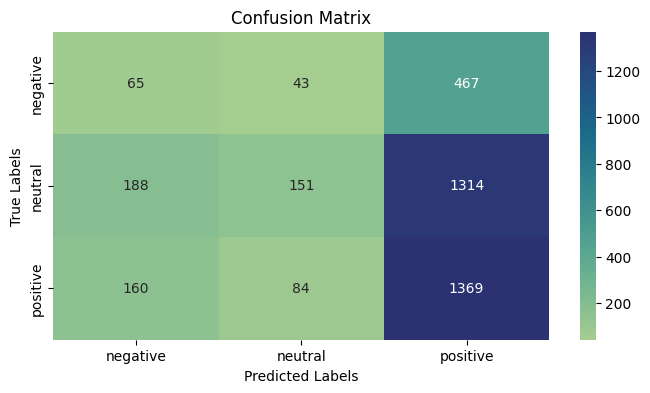

In [45]:
load_dataset = False

if load_dataset:
    joint_sentiment_analysis = joblib.load(f'{SAVE_DRIVE_PATH}/joint_sentiment_analysis.pkl')
else:
    joint_sentiment_analysis = SentimentAnalysis(
        train_df=amazon.dataset,
        test_df=semeval.dataset,
        class_labels=amazon.class_labels
    )
    joblib.dump(joint_sentiment_analysis, f'{SAVE_DRIVE_PATH}/joint_sentiment_analysis.pkl')

joint_sentiment_analysis.train_and_test()
joint_sentiment_analysis.visualize_confusion_matrix()

In [46]:
joint_sentiment_analysis.analyze_prediction_for_document(document_id=0, train_or_test='test')

Document: But the staff was so horrible to us.
True Sentiment: negative
Prediction: positive



,negative,neutral,positive
probability,0.307827,0.048718,0.643455


In [47]:
negative, neutral, positive = joint_sentiment_analysis.get_global_explain()
display(negative.head()), display(neutral.head()), display(positive.head())

,negative
peanuts,0.103975
jumbo,0.103975
red,0.100000
plan,0.100000
looking,0.093767


,neutral
mushy,0.143456
oaker,0.115470
see,0.115470
differce,0.115470
any,0.105561


,positive
<,0.122362
>,0.122362
/,0.111115
br,0.111115
's,0.086453


(None, None, None)

## Aspect Detection

In [83]:
class AspectDetection:
    def __init__(self, sentiment_analysis):
        self.clf = sentiment_analysis.clf
        self.vec = sentiment_analysis.vec
        self.features = sentiment_analysis.features
        self.class_labels = sentiment_analysis.class_labels
        self.train_df = sentiment_analysis.train_df
        self.test_df = sentiment_analysis.test_df
        self.X_train = sentiment_analysis.X_train
        self.X_test = sentiment_analysis.X_test

        self.train_df['NOUNS'] = self.train_df['Document'].apply(self.detect_nouns)
        self.test_df['NOUNS'] = self.test_df['Document'].apply(self.detect_nouns)

        self.train_df['PREDICTION'] = self.clf.predict(self.X_train)
        self.test_df['PREDICTION'] = self.clf.predict(self.X_test)
        # self.X_train = X_train

    # def is_noun(self, word):
    #     pos = pos_tag(word_tokenize(word))[0][1]
    #     return pos in ['NN', 'NNS', 'NNP', 'NNPS']

    def detect_nouns(self, document):
        doc = nlp(document)
        nouns = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']]
        return nouns

    def shorten_aspect_tokens(self, set1, set2):
        '''
        This function aims to match the tokens in set1 with the tokens in set2 in cases
        that the string in one set is substring in another. For example, when dealing
        with evaluation of aspects such as "battery life", it could be seen equivalent
        to "battery" or "battery life expectancy" for a more accurate evaluation.
        '''
        set1_reduced = set()
        for t in set1:
            match_found = False
            for c in set2:
                if t in c:
                    set1_reduced.add(t)
                    match_found = True
                    break
                elif c in t:
                    set1_reduced.add(c)
                    match_found = True
                    break
            if not match_found:
                set1_reduced.add(t)
        return set1_reduced

    def get_candidates(self, idx, train_or_test='train', threshold_aspect=0):
        '''
        For a given vectoried document, first we compute its overall sentiment, based
        on which we retrieve the corresponding explanatory features. Then, we keep the
        non-zero features (controlled by threshold) and sort them in descending
        order as candidates.
        '''
        if train_or_test == 'train':
            vectorized_doc = self.X_train[idx]
            PREDICTION = self.train_df.loc[idx, 'PREDICTION']
            NOUNS = self.train_df.loc[idx, 'NOUNS']

        elif train_or_test == 'test':
            vectorized_doc = self.X_test[idx]
            PREDICTION = self.test_df.loc[idx, 'PREDICTION']
            NOUNS = self.test_df.loc[idx, 'NOUNS']

        local_explain = pd.DataFrame(self.clf.explain(vectorized_doc).toarray(), index=self.features, columns=self.class_labels)
        candidates = local_explain[PREDICTION][local_explain[PREDICTION] > threshold_aspect]
        return [candidate for candidate in candidates.index if candidate in NOUNS]

    def evaluate_aspect_detection(self, threshold_aspect=0):
        '''
        True Positive (TP): Elements in both candidate_set and true_set.
        False Positive (FP): Elements in candidate_set but not in true_set.
        False Negative (FN): Elements in true_set but not in candidate_set.
        True Negative (TN): Rewarded when both sets are empty
        '''
        TP, FP, TN, FN = 0, 0, 0, 0
        true_aspects = self.train_df['aspects'].tolist()
        candidate_aspects = [self.get_candidates(self.clf, vectorized_doc=self.X_train[idx], threshold_aspect=threshold_aspect)
                            for idx in self.train_df.index]

        for candidate_aspect, true_aspect in zip(candidate_aspects, true_aspects):
            candidate_aspect = self.shorten_aspect_tokens(set(candidate_aspect), set(true_aspect))
            true_aspect = self.shorten_aspect_tokens(set(true_aspect), set(candidate_aspect))

            TP += len(candidate_aspect & true_aspect)
            FP += len(candidate_aspect - true_aspect)
            FN += len(true_aspect - candidate_aspect)
            TN += 1 if not candidate_aspect and not true_aspect else 0

        confusion_matrix = pd.DataFrame(np.array([[TP, FN],[FP, TN]]),
            index=['Aspect', 'Non-Aspect'],
            columns=['Aspect', 'Non-Aspect'])

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        evaluation_metrics = {'confusion_matrix': confusion_matrix, 'accuracy': accuracy,
                              'precision': precision, 'recall': recall, 'f1': f1}
        return evaluation_metrics

    def find_aspect_in_sentences(self, aspect, sentences, transformed_sentences):
        '''
        First, it finds the index of the aspect in the whole vocabulary, which might
        have been transformed in any way (bigram, lemma, lowercase). Then, it finds
        the first-matching sentence in the list of given sentences and returns it
        '''
        aspect_index = self.vec.vocabulary_.get(aspect)
        for sentence, transformed_sentence in zip(sentences, transformed_sentences):
            if transformed_sentence[0, aspect_index] > 0:
                return {aspect: sentence}

    def get_sentences_for_aspects(self, document, aspects):
        '''
        For a given document (which might contain multiple sentences), it splits
        the doc into sentences, transform them using the same transformation on
        aspects, and returns the first-matching sentence for each aspect.
        '''
        sentences = sent_tokenize(document)
        transformed_sentences = vec.transform(sentences)
        return [self.find_aspect_in_sentences(aspect, sentences, transformed_sentences) for aspect in aspects]


AD = AspectDetection(semeval_sentiment_analysis)

### Sample Aspect Detection and Token Shortener

In [98]:
document_id = 15
row = AD.train_df.iloc[document_id]

document = row['Document']
true_aspects = row['Aspects']
candidate_aspects = AD.get_candidates(document_id, train_or_test='train', threshold_aspect=0)

print(f'Document: {document}\nTrue Aspects: {true_aspects}\nDetected Aspects: {detected_aspects}')

Document: The pizza is the best if you like thin crusted pizza.
True Aspects: ['pizza', 'thin crusted pizza']
Detected Aspects: ['pizza']


In [100]:
true_aspects_shortened = AD.shorten_aspect_tokens(true_aspects, candidate_aspects)
candidate_aspects_shortened = AD.shorten_aspect_tokens(candidate_aspects, true_aspects)

print(f'Shortened Candidate Aspects: {true_aspects_shortened}')
print(f'Shortened True Aspects: {candidate_aspects_shortened}')

Shortened Candidate Aspects: {'pizza'}
Shortened True Aspects: {'pizza'}


### Optimize Aspect Detection Threshold

In [ ]:
evaluation_metrics_list = list()
aspect_thresholds = np.linspace(0.00001, 0.0001, 3)
best_aspect_threshold = None
best_f1_score = 0

for aspect_threshold in tqdm(aspect_thresholds):
    evaluation_metrics = AD.evaluate_aspect_detection(aspect_threshold)
    del evaluation_metrics['confusion_matrix']
    if evaluation_metrics['f1'] > best_f1_score:
        best_f1_score = evaluation_metrics['f1']
        best_aspect_threshold = aspect_threshold
    evaluation_metrics_list.append(evaluation_metrics)

print(f'Best Aspect Threshold: {best_aspect_threshold}')
print(f'F1-Score: {best_f1_score}')

  0%|          | 0/3 [00:00<?, ?it/s]

Best Aspect Threshold: 1e-05
F1-Score: 0.40413350090769445


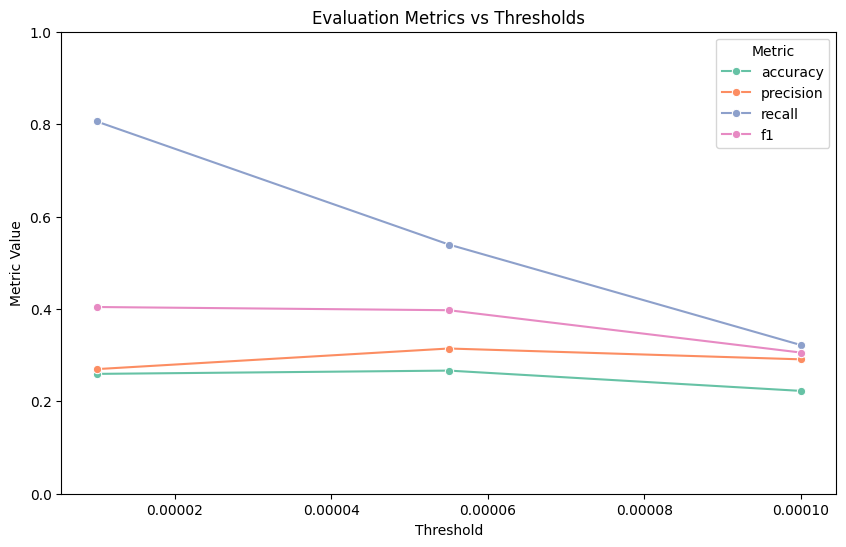

In [ ]:
metrics_df = pd.DataFrame(evaluation_metrics_list)
metrics_df['Threshold'] = aspect_thresholds
metrics_df = metrics_df.melt(id_vars='Threshold', var_name='Metric', value_name='Value')

visualize_aspect_detection_evaluation(metrics_df)

### Overall Aspect Detection Evaluation

In [ ]:
best_aspect_threshold = 0.004

In [ ]:
evaluation_metrics = AD.evaluate_aspect_detection(best_aspect_threshold)
cm = evaluation_metrics['confusion_matrix']
del evaluation_metrics['confusion_matrix']
pd.DataFrame([evaluation_metrics], index=['value'])

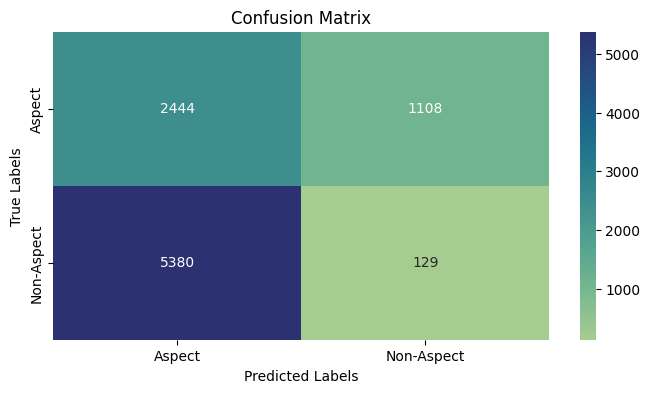

In [ ]:
visualize_confusion_matrix(cm, pred_labels=cm.columns, true_labels=cm.index)

In [ ]:
# true_aspects = train_df['aspects'].tolist()
# candidate_aspects = [AD.get_candidates(clf, vectorized_doc=X_train[idx]) for idx in train_df.index]
# for i in range(len(candidate_aspects)):
#     print(i, candidate_aspects[i], true_aspects[i])

## Association of Aspects to Text

In [ ]:
document_id = 3
document = test_df.loc[document_id, 'document']
test_df.iloc[document_id]

,3
document,Did I mention that the coffee is OUTSTANDING?
aspects,[coffee]
aspect_sentiments,[positive]
overall_sentiment,positive


In [ ]:
vectorized_doc = X_test[document_id]
best_aspect_threshold = 0.00001
candidate_aspects = AD.get_candidates(clf, vectorized_doc, best_aspect_threshold)
candidate_aspects

['coffee', 'i', 'mention']

In [ ]:
aspect_sentence_pairs = AD.get_sentences_for_aspects(document, candidate_aspects)
for idx, pair in enumerate(aspect_sentence_pairs):
    for aspect, sentence in pair.items():
        prediction = clf.predict(vec.transform([sentence]))[0]
        print(f'Sentence: {sentence}\nAspect: {aspect}\nPrediction: {prediction}')
        if idx != len(aspect_sentence_pairs) - 1: print('-' * 80)

Sentence: Did I mention that the coffee is OUTSTANDING?
Aspect: coffee
Prediction: negative
--------------------------------------------------------------------------------
Sentence: Did I mention that the coffee is OUTSTANDING?
Aspect: i
Prediction: negative
--------------------------------------------------------------------------------
Sentence: Did I mention that the coffee is OUTSTANDING?
Aspect: mention
Prediction: negative


## TODO

In [ ]:
# try bigrams + mutual info
# work on time efficiency of get_candidate_aspects

In [ ]:
def get_candidates(self, idx, threshold_aspect=0.004):
    '''
    For a given vectoried document, first we compute its overall sentiment, based
    on which we retrieve the corresponding explanatory features. Then, we keep the
    non-zero features (controlled by threshold) and sort them in descending
    order as candidates.
    '''
    vectorized_doc = self.X_train[idx]
    prediction = self.clf.predict(vectorized_doc)[0]
    local_explain = pd.DataFrame(self.clf.explain(vectorized_doc).toarray(), index=self.features, columns=self.class_labels)
    candidates = local_explain[prediction][local_explain[prediction] > threshold_aspect]

    candidate_aspects = candidates[candidates.index.to_series().apply(self.is_noun)]
    return candidate_aspects.index.tolist()

In [ ]:
def get_candidate_aspects(vectorized_doc, nouns, threshold_aspect=0):
    prediction = clf.predict(vectorized_doc)[0]
    local_explain = pd.DataFrame(clf.explain(vectorized_doc).toarray(), index=AD.features, columns=AD.class_labels)
    candidates = local_explain[prediction][local_explain[prediction] > threshold_aspect]
    return [candidate for candidate in candidates.index if candidate in nouns]

train_df.apply(lambda d: get_candidate_aspects(X_train[d.name], d.NOUNS), axis=1)

In [ ]:
import time

def get_candidate_aspects(vectorized_doc, nouns, threshold_aspect=0):
    start_time = time.time()  # Start timing the function

    prediction = clf.predict(vectorized_doc)[0]
    mid_time = time.time()
    print(f"Time for prediction: {mid_time - start_time} seconds")

    local_explain = pd.DataFrame(clf.explain(vectorized_doc).toarray(), index=AD.features, columns=AD.class_labels)
    mid_time_2 = time.time()
    print(f"Time for explanation dataframe: {mid_time_2 - mid_time} seconds")

    candidates = local_explain[prediction][local_explain[prediction] > threshold_aspect]
    mid_time_3 = time.time()
    print(f"Time for selecting candidates: {mid_time_3 - mid_time_2} seconds")

    result = [candidate for candidate in candidates.index if candidate in nouns]
    end_time = time.time()
    print(f"Time for final filtering: {end_time - mid_time_3} seconds")
    print('-'*80)

    return result

train_df.apply(lambda d: get_candidate_aspects(X_train[d.name], d.NOUNS), axis=1)

Time for prediction: 0.25176453590393066 seconds
Time for explanation dataframe: 0.26604199409484863 seconds
Time for selecting candidates: 0.19216537475585938 seconds
Time for final filtering: 0.00015926361083984375 seconds
--------------------------------------------------------------------------------
Time for prediction: 0.19666743278503418 seconds
Time for explanation dataframe: 0.2236635684967041 seconds
Time for selecting candidates: 0.17153286933898926 seconds
Time for final filtering: 0.0009455680847167969 seconds
--------------------------------------------------------------------------------
Time for prediction: 0.25000834465026855 seconds
Time for explanation dataframe: 0.26696014404296875 seconds
Time for selecting candidates: 0.15448951721191406 seconds
Time for final filtering: 0.00013113021850585938 seconds
--------------------------------------------------------------------------------
Time for prediction: 0.2714881896972656 seconds
Time for explanation dataframe: 0.27

KeyboardInterrupt: 

In [ ]:
threshold_aspect = 0
prediction = clf.predict(vectorized_doc)[0]
local_explain = pd.DataFrame(clf.explain(vectorized_doc).toarray(), index=AD.features, columns=AD.class_labels)
candidates = local_explain[prediction][local_explain[prediction] > threshold_aspect]
candidates

,negative
?,0.001246
coffee,0.000079
did,0.001116
i,0.000055
is,0.000131
mention,0.000108
outstanding,0.000205
that,0.000118
the,0.000158


## NLTK

In [ ]:
sample_text = "I love this product! It's amazing."

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

_ = nltk.download('vader_lexicon', quiet=True)
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_analyzer.polarity_scores(sample_text)

{'neg': 0.0, 'neu': 0.266, 'pos': 0.734, 'compound': 0.8516}

## RoBERTa

In [ ]:
sample_text = "I love this product! It's amazing."

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
encoded_text = tokenizer(sample_text, return_tensors='pt')
output = model(**encoded_text)[0][0]
scores = softmax(output.detach().numpy())
neg, neu, pos = scores
scores

array([0.00212159, 0.00545376, 0.9924246 ], dtype=float32)

## References

- Emanuele Guidotti and Alfio Ferrara. Text Classification with Born’s Rule. Advances in Neural Information
Processing Systems, 2022.
- Schouten, K., & Frasincar, F. (2015). Survey on aspect-level sentiment analysis. IEEE Transactions on
Knowledge and Data Engineering, 28(3), 813-830. [link](https://ieeexplore.ieee.org/document/7286808)
- Rana, T. A., & Cheah, Y. N. (2016). Aspect extraction in sentiment analysis: comparative analysis and survey.
Artificial Intelligence Review, 46(4), 459-483. [link](https://link.springer.com/article/10.1007/s10462-016-9472-z)